# Comparison of BootComp against OBCA-m on single objective problems
This notebook implements the **OCBA-m** algorithm.

Source of algorithm. Chen et al. (2008) 

**Efficient Simulation Budget Allocation for Selecting an Optimal Subset**

https://pubsonline.informs.org/doi/pdf/10.1287/ijoc.1080.0268

---

# **Parameter to help reproducibility test**
This version of the notebook has been modified to help with reproducing the results reporting in the paper.

> Advice: the parameter `N_EXPERIMENTS` controls the total number of times that the analysis is repeated.  Runtimes can take several hours for large values. It is recommended that a small number is tested initially (e.g. 10) to ensure that notebook runs all the way through without crashing and wasting computation time.  The parameter `PLOT_BC_COMPARISON` will create basic reproducition of figure 2 plot from the paper. Note this is relies on data the bootcomp experimental results being available the `./results` directory.

In [ ]:
#In the paper we ran 10,000 experiments for each replication budget.
N_EXPERIMENTS = 10_000

In [ ]:
#plot figure 2 after the current batch of experiments.
PLOT_BC_COMPARISON = True

---

In [3]:
import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Utility funcs

In [4]:
def load_system(file_name, system, reps, reps_available, delim=','):
    """
    Reads system data from a txt file (assumes comma delimited by default).  
    Assumes that each column represents a system.
    Returns a numpy array.  Each row is a system (single row); each col is a replication
    
    
    @file_name = name of file containing csv data
    @system = index of system in txt file.
    @reps = replications wanted
    @reps_available = total number of replications that has been simulated.
    @delim = delimiter of file.  Default = ',' for CSV.  

    """
    
    return np.genfromtxt(file_name, delimiter=delim, usecols = system, skip_footer = (reps_available - reps))

In [5]:
def simulate(data, k, allocations):
    """
    Simulates the systems.  
    Each system is allocated a different budget of replications
    
    Returns list of numpy arrays
    
    @allocations = numpy array.  budget of replications for the k systems 
    """
    return [data[i][0:allocations[i]] for i in range(k)]
    

In [6]:
def get_ranks(array):
    """
    Returns a numpy array containing ranks of numbers within a input numpy array
    e.g. [3, 2, 1] returns [2, 1, 0]
    e.g. [3, 2, 1, 4] return [2, 1, 0, 3]
        
    @array - numpy array (only tested with 1d)
        
    """
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return ranks

In [7]:
#@jit(nopython=True)
def bootstrap(data, boots=1000, random_state=None):
    """
    Returns a numpy array containing the bootstrap resamples
    Useful for creating a large number of experimental datasets 
    for testing R&S routines
    
    Keyword arguments:
    data -- numpy.ndarray of systems to boostrap
    boots -- integer number of bootstraps (default = 1000)
    random_state -- int, set the numpy random number generator
    """
    
    np.random.seed(random_state)
    experiments = boots
    designs = 10
    samples = data.shape[1]
     
    datasets = np.zeros((experiments, designs, samples))
     
    for exp in range(experiments):
        
        for design in range(designs):

            for i in range(samples):

                datasets[exp][design][i] = data[design][round(np.random.uniform(0, samples)-1)]
      
    return datasets

In [8]:
#@jit(nopython=True)
def crn_bootstrap(data, boots=1000, random_state=None):
    """
    Returns a numpy array containing the bootstrap resamples
    Useful for creating a large number of experimental datasets 
    for testing R&S routines.  This function assumes common
    random numbers have been used to create the original data.
    
    Keyword arguments
    data -- numpy.ndarray of systems to boostrap
    boots -- integer number of bootstraps (default = 1000)
    random_state -- int, set the numpy random number generator
    """
    
    np.random.seed(random_state)

    experiments = boots
    designs = data.shape[0]
    samples = data.shape[1]
    
    datasets = np.zeros((experiments, designs, samples))
     
    for exp in range(experiments):
        
         for i in range(samples):

                row = data.T[np.random.choice(data.shape[0])]
                
                for design in range(designs):
                    datasets[exp][design][i] = row[design]  
      
    return datasets

# Walk through of how Ocba-m works

##  Input

**k** = total number of designs

**m** = no. of top designs to select

**T** = total budget (replications)

**n_0** = l number of replications  (>=5)

**delta** - additional budget to allocate between each simulation  

*where T - k.n_0 is a multiple of delta*


### Full Implementation 

In [9]:
@jit(nopython=True)
def summary_statistics(systems, allocations):
    means = np.array([array.mean() for array in systems])
    stds = np.array([array.std() for array in systems])
    ses = np.divide(stds, np.sqrt(allocations))
    
    return means, ses

In [10]:
def top_m(means, m):
    """
    Returns the top m system designs
    Largest sample means
    """
    ranks = get_ranks(means)
    return np.argpartition(ranks, -m)[-m:]

In [11]:
def bottom_m(means, m):
    """
    Returns the bottom m system designs
    Smallest sample means
    """
    ranks = get_ranks(means)
    return np.argpartition(ranks, m)[:m]

In [12]:
@jit(nopython=True)
def parameter_c(means, ses, k, m):
    order = np.argsort(means)
    s_ses = ses[order]
    s_means = means[order]

    return((s_ses[k-m+1] * s_means[k-m]) + (s_ses[k-m] * s_means[k-m+1]))/(s_ses[k-m]+s_ses[k-m+1])  

In [13]:
def ocba_m(dataset, k, allocations, T, delta, m):
    
    while allocations.sum() < T:
        
        #simulate systems using new allocation of budget
        reps = simulate(dataset, k, allocations) 
        
        #calculate sample means and standard errors
        means, ses = summary_statistics(reps, allocations)
        
        #calculate parameter c and deltas
        c = parameter_c(means, ses, k, m)
        deltas = means - c
        
        #allocate
        for i in range(delta):
            values = np.divide(allocations, np.square(np.divide(ses, deltas)))
            ranks = get_ranks(values)
            allocations[ranks.argmin()] += 1
            
    return means, ses, allocations

In [14]:
def cs(selected_top_m, true_top_m):
    """
    Returns boolean value.  
    True = correct selection of top m
    False = incorrect selection (one or more of selected top m is incorrect)
    
    Keyword arguments:
    selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return np.array_equal(np.sort(selected_top_m), true_top_m)

In [15]:
def oc(true_means, selected_top_m, true_top_m):
    """
    Return the opportunity cost of the selection
    Method penalised particular bad solutions more than mildly bad
    
    @true_means - numpy.array of true means
    @selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    @true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return (true_means[selected_top_m] - true_means[true_top_m]).sum()

In [16]:
def p_cs(correct_selections):
    """
    Returns the probability of correct selection P{cs}
    Keyword arguments:
    
    correct_selections - list indicating if a given budget found the top m e.g. [False, True, True]
    """
    return np.array(correct_selections).sum() / len(correct_selections)

In [17]:
def p_cs2(correct_selections):
    """
    Returns the probability of correct selection P{cs}
    
    @correct_selections - numpy.array of budget versus exp. Contains True or False indicating correct selection.
    
    """
    return np.mean(correct_selections, axis=1)

In [18]:
def e_oc(opportunity_costs):
    """
    Return the expected opportunity cost E{oc}
    
    @opportunity costs - arrange of opportunity cost per budget
    """
    return np.array(opportunity_costs).mean()

In [19]:
def e_oc2(opportunity_costs):
    """
    Return the expected opportunity cost E{oc}
    
    @opportunity costs - arrange of opportunity cost per budget
    """
    return np.mean(opportunity_costs, axis=0)

# Numerical test - single experiment

### Create Experimental Data

#### Use the following code to create independent samples

In [20]:
def experiments_independent_samples(ifile_name, boots=1000, random_state=None):
    data = np.genfromtxt(ifile_name, delimiter=",", skip_footer=0).transpose()
    experiments = bootstrap(data, boots=boots, random_state=random_state)
    return experiments

#### Use the following code to create CRN data sets

In [21]:
def experiments_dependent_samples(ifile_name, boots=1000, random_state=None):
    data = np.genfromtxt(ifile_name, delimiter=",", skip_footer=0).transpose()
    experiments = crn_bootstrap(data, boots=boots, random_state=random_state)
    return experiments

Use the `numerical_experiment()` function to run experiments of OBCA-m across multiple experimental datasets and budgets.

For example, you may have 100 datasets to test across budgets of 1000, 2000, 3000 and 4000 replications.

In [22]:
def numerical_experiment(experiments, budgets, delta, true_top_m, n_0,
                         opt='max'):
    """
    Conduct a user set number of numerical experiments on the algorithm
    for different computational budgets
    
    Returns:
    1. numpy.array containing P{cs} for each budget
    2. numpy.array containing E{oc} for each budget
    
    Keyword arguments:
    experiments -- numpy.array[experiments][designs][replication]
    budgets -- python.list containing budgets
    delta - maximum amount of budget to allocate per run. 
    true_top_m -- top m (i.e. the systems that should be returned)
    n_0 -- initial number of replications per system
    
    """
    n_experiments = experiments.shape[0]
    k = experiments.shape[1]
    m = true_top_m.shape[0]
        
    correct_selections = np.zeros((n_experiments, len(budgets)))
    opportunity_costs = np.zeros((n_experiments, len(budgets)))

    for exp in range(n_experiments):

        for t in range(len(budgets)):

            allocations = np.full(k, n_0, dtype=int)
                        
            means, ses, allocations = ocba_m(experiments[exp], k, 
                                             allocations, budgets[t], 
                                             delta, m)
            
            
            if opt == 'max':
                selected_top_m = top_m(means, m)
            else:
                selected_top_m= bottom_m(means, m)

            correct_selections[exp][t] = cs(selected_top_m, true_top_m)
            
    return correct_selections

# Experiments for CRN data

In [23]:
def get_budgets(max_t, min_t, increment_t):
    #incremental budgets 200, 400, .... T
    budgets = [i for i in range(min_t, max_t + increment_t, increment_t)]
    return budgets

In [24]:
def experiment_1():
    T = 5000
    increment_t = 200
    min_budget = 600
    n_0 = 20
    delta = 50
    seed = 101
    
    ####################################
    # Set this parameter to determine no. of sample/runs
    n_experiments = N_EXPERIMENTS
    ####################################

    #data file for this experiment.
    ifile_name = 'data/EG1a_CRN.csv'

    #info for correct selection
    true_top_m = np.array([7, 8, 9])

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #generate experimental dataset
    experiments = experiments_dependent_samples(ifile_name, 
                                                boots=n_experiments,
                                                random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, budgets, delta, true_top_m, n_0)
    
    return css

In [25]:
def experiment_1a_No_CRN():
    T = 5000
    increment_t = 200
    min_budget = 600
    n_0 = 20
    delta = 50
    seed = 101
    
    ####################################
    # Set this parameter to determine no. of sample/runs
    n_experiments = N_EXPERIMENTS
    ####################################

    #data file for this experiment.
    ifile_name = 'data/EG1a_CRN.csv'

    #info for correct selection
    true_top_m = np.array([7, 8, 9])

    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #generate experimental dataset
    experiments = experiments_independent_samples(ifile_name, 
                                                  boots=n_experiments,
                                                  random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, budgets, delta, true_top_m, n_0)
    
    return css

## Experiments for Law Inventory Example

### Maximisation Example (Top 3)

In [26]:
def experiment_2():
    T = 1000
    increment_t = 100
    min_budget = 300
    n_0 = 20
    delta = 50
    seed = 101
    
    ####################################
    # set this parameter for number of samples/runs.
    n_experiments = N_EXPERIMENTS
    ####################################

    #data file for this experiment
    ifile_name = 'data/EGLaw_CRN.csv'
    
    #info for correct selection (maximisation problem)
    true_top_m = np.array([6, 7, 8]) 
    
    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #generate experimental dataset
    experiments = experiments_dependent_samples(ifile_name, 
                                                boots=n_experiments,
                                                random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, budgets, delta, true_top_m, n_0)
    
    return css

### Minimisation Example (Bottom 2)

In [27]:
def experiment_3():
    T = 1000
    increment_t = 100
    min_budget = 300
    n_0 = 20
    delta = 50
    seed = 101
    
    ####################################
    # set this parameter for number of samples/runs.
    n_experiments = N_EXPERIMENTS
    ####################################

    #data file for this experiment
    ifile_name = 'data/EGLaw_CRN.csv'
    
    #info for correct selection (maximisation problem)
    true_top_m = np.array([1, 2]) 
    
    #incremental budgets 200, 400, .... T
    budgets = get_budgets(T, min_budget, increment_t)
    
    #generate experimental dataset
    experiments = experiments_dependent_samples(ifile_name, 
                                                boots=n_experiments,
                                                random_state=seed)
    
    #run numerical experiment
    css = numerical_experiment(experiments, budgets, delta, true_top_m, n_0, 
                               opt='min')
    
    return css

# Run Experiments

## Section 4.4.1 in paper. 

### **Experiment 1: Independent samples (no CRN). OCBA-m 10 design problem.**

Both OCBA-m and BootComp were run with 20 initial replications for each design (n1=20)

In [28]:
results_1 = experiment_1()
pd.DataFrame(results_1).shape

(10000, 23)

## Section 4.1.2 in paper

### **Experiment 1a: CRN. OCBA-m 10 design problem.**

In [29]:
results_1a = experiment_1a_No_CRN()
pd.DataFrame(results_1a).shape

(10000, 23)

## Section 4.1.3 in paper

### **Experiment 2: CRN. Law Inventory Example****



In [30]:
results_law_max = experiment_2()
pd.DataFrame(results_law_max).shape

(10000, 8)


## Section 4.1.3 in paper
### **Experiment 3: CRN. Law Inventory Example**



In [31]:
results_law_min = experiment_3()
pd.DataFrame(results_law_min).shape

(10000, 8)

# Summary of experimental results.

In [32]:
def format_results(df_results, budgets):
    '''
    Format experimental results in a table
    summarising PCS
    
    Params:
    ------
    df_results: pd.DataFrame
        Experimentation results.  (N_EXPERIMENTS, len(budgets))
        
    budget: array-like
        list of replication budgets.
        
    '''
    budgets = pd.DataFrame(budgets, columns=['budget'])
    count = pd.DataFrame(df_results).sum()
    pcs = pd.DataFrame(df_results).mean()
    pcs.name = 'pcs'
    count.name = 'n'
    pcs = pd.concat([budgets, count, pcs], axis=1)
    return pcs

## Section 4.4.1 in paper.  OCBA-m dataset - 10 systems. CRN

In [33]:
T = 5000
increment_t = 200
min_budget = 600

budgets = get_budgets(T, min_budget, increment_t)
pcs_1 = format_results(results_1, budgets)
pcs_1

,budget,n,pcs
0,600,9934.0,0.9934
1,800,9993.0,0.9993
2,1000,9997.0,0.9997
3,1200,9999.0,0.9999
4,1400,10000.0,1.0000
5,1600,10000.0,1.0000
6,1800,10000.0,1.0000
7,2000,10000.0,1.0000
8,2200,10000.0,1.0000
9,2400,10000.0,1.0000


## Section 4.1.2 in paper. OCBA-m dataset - 10 systems Independent samples

The results illustrate the importance of CRN in variance reduction and, as expected, BootComp loses its advantage over OCBA-m in examples where samples are independent. Without CRN, BootComp was unable to match OCBA-m under any of the budget assumptions we included. This is not unexpected as OCBA-m is a sequential algorithm and BootComp includes only two stages. 

In [34]:
T = 5000
increment_t = 200
min_budget = 600

budgets = get_budgets(T, min_budget, increment_t)
pcs_1a = format_results(results_1a, budgets)
pcs_1a


,budget,n,pcs
0,600,8660.0,0.8660
1,800,9183.0,0.9183
2,1000,9475.0,0.9475
3,1200,9635.0,0.9635
4,1400,9752.0,0.9752
5,1600,9830.0,0.9830
6,1800,9893.0,0.9893
7,2000,9927.0,0.9927
8,2200,9950.0,0.9950
9,2400,9971.0,0.9971


In [35]:
def plot_exp1_versus_bootcomp(df):
    '''
    Basic plot of the results.
    '''
    
    bootcomp_results = './figure_data/figure2_bootcomp_data.csv'
    bootcomp_results2 = './figure_data/figure2_bootcomp_data2.csv'
    alpha1_0point2 = pd.read_csv(bootcomp_results)
    alpha1_0point3 = pd.read_csv(bootcomp_results2)
    
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    ax.plot(df['budget'], df['pcs'], linewidth=3)
    ax.plot(alpha1_0point2['budget'], alpha1_0point2['pcs'], 
            marker='^', linestyle='',  markersize=6)
    ax.plot(alpha1_0point3['budget'], alpha1_0point3['pcs'], 
            marker='s', linestyle='',  markersize=6)
    
    ax.legend(['OCBA-m', r'BootComp $\alpha_1$=0.2', 
               r"BootComp $\alpha_1$=0.3"], 
              fontsize=12, loc=0);

    ax.set_xlabel('Replication Budget')
    ax.set_ylabel('P(CS)')

In [36]:
def plot_experiment1(df):
    '''
    plot OCBA versus bootcomp for no CRN
    '''
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.plot(df['budget'], df['pcs'], linewidth=3)

    ax.set_xlabel('Replication Budget')
    ax.set_ylabel('P(CS)')

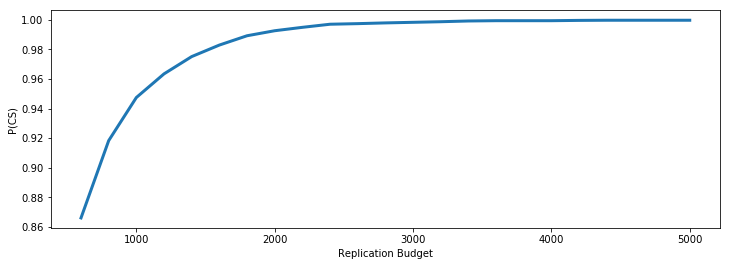

In [37]:
#plot from budget 600+
plot_experiment1(pcs_1a)

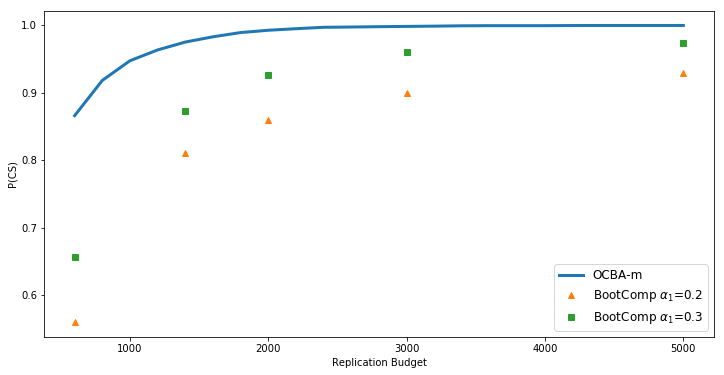

In [38]:
if PLOT_BC_COMPARISON:
    plot_exp1_versus_bootcomp(pcs_1a)

# Section 4.1.3 in paper: Experiments for Law Inventory example

In the inventory example, full synchronization has not been achieved, but CRN has still induced a high positive correlation across the nine designs. Both OCBA-m and BootComp select the top three designs (highest mean) in all 10,000 experiments for each budget.

In [39]:
T = 1000
increment_t = 100
min_budget = 300

#incremental budgets 200, 400, .... T
budgets = get_budgets(T, min_budget, increment_t)
pcs_2 = format_results(results_law_max, budgets)
pcs_2

,budget,n,pcs
0,300,10000.0,1.0
1,400,10000.0,1.0
2,500,10000.0,1.0
3,600,10000.0,1.0
4,700,10000.0,1.0
5,800,10000.0,1.0
6,900,10000.0,1.0
7,1000,10000.0,1.0


In [40]:
T = 1000
increment_t = 100
min_budget = 300

#incremental budgets 200, 400, .... T
budgets = get_budgets(T, min_budget, increment_t)
pcs_3 = format_results(results_law_min, budgets)
pcs_3

,budget,n,pcs
0,300,10000.0,1.0
1,400,10000.0,1.0
2,500,10000.0,1.0
3,600,10000.0,1.0
4,700,10000.0,1.0
5,800,10000.0,1.0
6,900,10000.0,1.0
7,1000,10000.0,1.0
